In [52]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.decomposition import CanICA

import os
import scipy as sp
import scipy.stats as stats
import pandas as pd


In [3]:
# img_dir='D:\laptop\Bishops\\bishopsLecturesWin2022\\term2\MLDrRussell\FinalProject\\final_project_subjects_1-3\watch_02\\'

# bold=nib.load(img_dir+'fmri.nii.gz')
# bold_data=nib.load(img_dir+'fmri.nii.gz').get_fdata()
bold=[]
bold_data=[]
LV=[]
LV_data=[]
aorta=[]
aorta_data=[]
carotid=[]
carotid_data=[]

hdr=[]
img=[]

for n1 in (2,3,4,5,6,7):
    LV.append(nib.load(f'left_ventricle_4d{n1}.nii.gz'))
    LV_data.append(LV[n1-2].get_fdata())

# for  n in range(1,8):
   
#     bold.append(nib.load(f'fmri{n}.nii.gz'))
#     bold_data.append(bold[n-1].get_fdata())
    
    # aorta.append(nib.load(f'qflow_aorta{n}.nii.gz'))
    # aorta_data.append(aorta[n-1].get_fdata())
   
    # carotid.append(nib.load(f'qflow_carotid{n}.nii.gz'))
    # carotid_data.append(carotid[n-1].get_fdata())

   


In [ ]:
# preprocessing of Fmri Image by apply motion correction ( use FSL command mcflirt)
import nipype.interfaces.fsl as fsl
mcflt = fsl.MCFLIRT()

#create function to do motion correction of nii.gz image  by MCFLIRT
def mcflirt(img,m):
    mcflt.inputs.in_file = img
    mcflt.inputs.cost = 'mutualinfo'
    mcflt.inputs.out_file =f'mcflt_fmri{m}.nii.gz'
     
    mcflt.cmdline
    f'mcflirt -in{img} -cost mutualinfo -out mcflt_fmri{m}.nii.gz'
    # f'mcflirt -in{img} -cost mutualinfo -out {img_dir_out}mcflt_bold.nii.gz'
    res = mcflt.run()  
    return res.outputs.out_file

#call function to do motion correction
for m in range(1,8):
   mcflirt(f'fmri{m}.nii.gz',m) 


In [ ]:
# plot mcflt_bold image
bold_fmri=[]
for i in range(1,8):
    plt.subplot(3,3,i)
    bold_fmri.append(nib.load(f'mcflt_fmri{i}.nii.gz').get_fdata())
    print(bold_fmri[i-1].shape)
    plt.imshow(bold_fmri[i-1][:,:,31,15])
    plt.title(f'mcflt_fmri{i}')
    plt.show()




In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.decomposition import CanICA
import scipy.signal as signal


folder = 'D:\\medical imaging\\finalprojectdataset\\final_project_subjects_1-3\\'
hdr=[]
img=[]
for i in range(0,7):
  hdr.append(nib.load(folder+f'mcflt_fmri{i+1}.nii.gz'))
  img.append(nib.load(folder+f'mcflt_fmri{i+1}.nii.gz').get_data())


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


ica=[]
comps=[]
for i in range(0,7):


  ica.append(CanICA())
  ica[i].fit(hdr[i]) 
  comps.append(ica[i].components_img_.get_data())
  
  plt.figure()
  for ii in np.arange(0,20):
    plt.subplot(4,5,ii+1)
    plt.imshow(np.mean(comps[i][:,:,:,ii],axis=2))
  print(f"fmri{i+1}")
  print(comps[i].shape)




In [ ]:

#we found the part of brain that is good for dmn and then we can find the region of x,y,z for potting the time series
for i in range(0,7): 
    if i==0:
        dmn_ind = 15
       
    if i==1:
        dmn_ind=10
        z=42
    if i==2:
        dmn_ind=11
       
    if i==3:
        dmn_ind=1
    if i==4:
        dmn_ind=15
    if i==5:
        dmn_ind=13
    if i==6:
        dmn_ind=8
   

    plt.figure()
    for ii in np.arange(0,42):


      plt.subplot(6,7,ii+1)
      
      plt.imshow(comps[i][:,:,ii,dmn_ind],vmin=0,vmax=0.02)
    plt .title(f"fmri{i+1}")

In [ ]:
#we find the appropriate seed in the shape and we can plot the time series of images then calculate the r value of images
def calc_r(img,y1,y2,x1,x2,z1,z2):
  plt.plot(np.mean(img[y1:y2,x1:x2,z1:z2,:],axis=(0,1,2)))
  # plt.title(f"fmri{i+1}")
  plt.show()
  newimg = np.zeros(img[:,:,:,0].shape)
  newimg[y1:y2,x1:x2,z1:z2] = 1 # sanity check ,display to make sure


  resimg = img.reshape([img[:,:,:,0].size,img.shape[3]])


  hp_fmri = butter_highpass_filter(resimg,cutoff=0.005,fs=1).reshape(img.shape)
  dmn_img = np.zeros(img.shape)
  mean_dmn_ts = np.mean(hp_fmri[y1:y2,x1:x2,z1:z2,:],axis=(0,1,2))
  dmn_img[:,:,:,:] = mean_dmn_ts
  r = np.sum(dmn_img*hp_fmri,axis=3) / np.sqrt((np.sum(dmn_img*dmn_img,axis=3) * np.sum(hp_fmri*hp_fmri,axis=3)))
  
  for ii in np.arange(0,42):
    plt.subplot(6,7,ii+1)
    
    plt.imshow(r[:,:,ii],vmin=-0.6,vmax=0.6)
  plt.show()
  return r


  
#call  the function to calculate the r value
r_value=[]
for i in range(0,6):
  if i==0:
    y1,y2,x1,x2,z1,z2=37,39,27,29,19,22
  if i==1:
    y1,y2,x1,x2,z1,z2=37,39,25,27,27,30
  if i==2:
    y1,y2,x1,x2,z1,z2=37,39,23,26,23,26
  if i==3:
    y1,y2,x1,x2,z1,z2=37,39,23,26,21,24
  if i==4:
    y1,y2,x1,x2,z1,z2=37,39,24,26,21,24
  if i==5:
    y1,y2,x1,x2,z1,z2=37,39,24,26,21,24
  if i==6:
    y1,y2,x1,x2,z1,z2= 35,40,20,30,18,20



  print(f"fmri{i+1}") 
  r_value.append(calc_r(img[i],y1,y2,x1,x2,z1,z2))


for j in range(0,7):    
  # calculate the mean of the r value for each voxel without nan values
  mean_r = np.nanmean(r_value[j],axis=(0,1,2))
  print(f"DMN (fmri{j} )={mean_r}")


In [ ]:
# Carotid...................................................
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

data_dir = '/Users/yasaman/Documents/Medical imaging/data/'
subjects = ['watch_01','watch_02','watch_03','watch_04','watch_05','watch_06','watch_07']

left_centers = [[73,108],[69,95],[69,96],[73,114],[66,124],[68,100],[66,135]]
right_centers = [[123,106],[128,92],[119,93],[123,115],[124,126],[115,96],[130,133]]

ts = np.zeros([7,2,40])

sub_ind = 0
for sub in subjects:
    carotid = nib.load(data_dir+sub+"/qflow_carotid.nii.gz").get_data()
    plt.figure()
    plt.subplot(3,2,1)
    plt.imshow(carotid[:,:,60])
    plt.subplot(3,2,2)
    plt.imshow(carotid[:,:,30]) 
    
    left = left_centers[sub_ind]
    left_img = carotid[left[0]-3:left[0]+3,left[1]-3:left[1]+3,40]
    left_inds = np.where(left_img.flatten() > 100)
    left_vel = carotid[left[0]-3:left[0]+3,left[1]-3:left[1]+3,0:40].reshape([36,40])
    
    right = right_centers[sub_ind]
    right_img = carotid[right[0]-3:right[0]+3,right[1]-3:right[1]+3,40]
    right_inds = np.where(right_img.flatten() > 100)
    right_vel = carotid[right[0]-3:right[0]+3,right[1]-3:right[1]+3,0:40].reshape([36,40])
    
    plt.subplot(3,2,3)
    plt.imshow(left_img,vmin=100,vmax=200)
    plt.title('left_carotid')
    plt.subplot(3,2,4)
    plt.imshow(right_img,vmin=100,vmax=200)
    plt.title('right_carotid')
    
    plt.subplot(3,2,5)
    plt.plot(left_vel[left_inds[0],:].T)
    plt.subplot(3,2,6)
    plt.plot(right_vel[right_inds[0],:].T)
    
    ts[sub_ind,0,:] = np.mean(left_vel[left_inds[0],:],axis=0)
    ts[sub_ind,1,:] = np.mean(right_vel[right_inds[0],:],axis=0)
    
    sub_ind += 1
 

max_vels = np.max(ts,axis=2)
mean_carotid_velocity=np.mean(max_vels,axis=1)



(7, 240, 240, 24)
(7, 240, 240, 24)
(240, 7, 240, 28)
(240, 7, 240, 24)
(7, 240, 240, 31)
(7, 240, 240, 36)


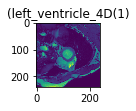

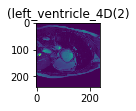

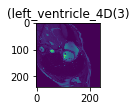

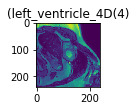

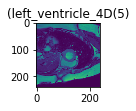

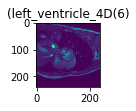

In [10]:
#Extract two separate time series 1) LV area and 2) average thickness of heart muscle
import scipy.ndimage as ndimage
img=[]
img_data=[]
# read the nifti image as 2d array
for i in range(1,7):
    img.append(LV[i-1])
    img_data .append(LV_data[i-1])
    print(img[i-1].shape)


# plot the 4d image
for j in range(1,7):
    plt.subplot(3,3,i)
    if j==1:
        plt.imshow(img_data[j-1][2,:,:,23]) 
        plt.title(f'(left_ventricle_4D({j})')
    elif j==2:
        plt.imshow(img_data[j-1][3,:,:,23]) 
        plt.title(f'(left_ventricle_4D({j})')
    elif j==3:
        plt.imshow(img_data[j-1][:,5,:,23])
        plt.title(f'(left_ventricle_4D({j})')
    elif j==4:
        plt.imshow(img_data[j-1][:,4,:,23])
        plt.title(f'(left_ventricle_4D({j})')
    elif j==5:
        plt.imshow(img_data[j-1][3,:,:,23])
        plt.title(f'(left_ventricle_4D({j})')
    elif j==6:
        plt.imshow(img_data[j-1][2,:,:,23])
        plt.title(f'(left_ventricle_4D({j})')
    plt.show()



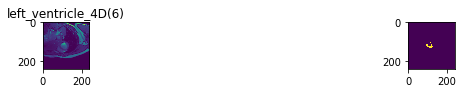

In [26]:
# denoise the image_data by median filter to dilation & erosion the image TO show the different part of image clearly
def img_denoise(img):
    img_data_denoise = ndimage.median_filter(img, size=4)
   
    # # plot the denoised image
    # plt.imshow(img_data_denoise[:,5,:,10])
    # plt.show()
    return img_data_denoise


# write function to check the homogeneity of the segmented image
def homeg(avg_old_point, new_point):
    return np.abs(avg_old_point - new_point)

# segmentation function by using region growing
def segmnetation_region_growing(img,img_segmentation , tresh,seed):
    # img_t=np.zeros(img.shape)

    #specify the seed point and set the seed point and evry point that is same as the ssed point equal to 1
    x=seed[0];y=seed[1];z=seed[2]
    img_segmentation[x,y,z]=1
    
    # calculate the average of pixels that specified the same as seed point to compare with threshold value
    avg=np.mean(img[np.where(img_segmentation==1)])

    # check matrix border and homegenous criterion for the 4-neighborhood
    if(x+1 < img.shape[0] and img_segmentation[x+1,y,z]==0 and homeg(avg,img[x+1,y,z])<=tresh):
    # if(x+1 < img.shape[0] and img_t[x+1,y,z]==0 and homeg(avg,img[x+1,y,z])<=tresh):
        segmnetation_region_growing(img,img_segmentation,tresh,[x+1,y,z])

    if(x-1 >= 0 and img_segmentation[x-1,y,z]==0 and homeg(avg,img[x-1,y,z])<=tresh):
        segmnetation_region_growing(img,img_segmentation,tresh,[x-1,y,z])

    if(y+1 < img.shape[1] and img_segmentation[x,y+1,z]==0 and homeg(avg,img[x,y+1,z])<=tresh):
        segmnetation_region_growing(img,img_segmentation,tresh,[x,y+1,z])
    
    if(y-1 >= 0 and img_segmentation[x,y-1,z]==0 and homeg(avg,img[x,y-1,z])<=tresh):
        segmnetation_region_growing(img,img_segmentation,tresh,[x,y-1,z])

    if(z+1 < img.shape[2] and img_segmentation[x,y,z+1]==0 and homeg(avg,img[x,y,z+1])<=tresh):
        segmnetation_region_growing(img,img_segmentation,tresh,[x,y,z+1])

    if(z-1 >= 0 and img_segmentation[x,y,z-1]==0 and homeg(avg,img[x,y,z-1])<=tresh):
        segmnetation_region_growing(img,img_segmentation,tresh,[x,y,z-1])

    # return img_segmentation  

# create img_segmentation by size img_data.shape[0] to hold the segmented image
img_segment=[]
for nn in range(1,7):
    img_segment.append(np.zeros(img_data[nn-1].shape[0:3]))

    # call the function to segment the image and save the segmented image in img_segment
    # set the seed point manually from the image to show more clearly the segmentation
    if nn==1:
        segmnetation_region_growing(img_denoise(img_data[nn-1])[:,:,:,23],img_segment[nn-1],220,[2,125,115])
        # plot the segmented image
        plt.figure(figsize=(12,6))
        plt.subplot(621); plt.imshow(img_data[nn-1][2,:,:,23])#; plt.axis('off')
        plt.title(f'left_ventricle_4D({nn})')
        plt.subplot(622); plt.imshow(img_segment[nn-1][2,:,:]*255)#; plt.axis('off')
        # plt.show()
    elif nn==2:
        segmnetation_region_growing(img_denoise(img_data[nn-1])[:,:,:,23],img_segment[nn-1],210,[3,115,115])
        # plot the segmented image
        plt.figure(figsize=(12,6))
        plt.subplot(623); plt.imshow(img_data[nn-1][3,:,:,23])
        plt.title(f'left_ventricle_4D({nn})')
        plt.subplot(624); plt.imshow(img_segment[nn-1][3,:,:]*255)#; plt.axis('off')
        # plt.show()
    elif nn==3:
        segmnetation_region_growing(img_denoise(img_data[nn-1])[:,:,:,23],img_segment[nn-1],255,[115,5,115])
        # plot the segmented image
        plt.figure(figsize=(12,6))
        plt.subplot(625); plt.imshow(img_data[nn-1][:,5,:,23])
        plt.title(f'left_ventricle_4D({nn})')
        plt.subplot(626); plt.imshow(img_segment[nn-1][:,5,:]*255)
    elif nn==4:
        segmnetation_region_growing(img_denoise(img_data[nn-1])[:,:,:,23],img_segment[nn-1],100,[120,4,125])
        # plot the segmented image
        plt.figure(figsize=(12,6))
        plt.subplot(627); plt.imshow(img_data[nn-1][:,4,:,23])
        plt.title(f'left_ventricle_4D({nn})')
        plt.subplot(628); plt.imshow(img_segment[nn-1][:,4,:]*255)
    elif nn==5:
        segmnetation_region_growing(img_denoise(img_data[nn-1])[:,:,:,23],img_segment[nn-1],180,[3,115,120])
        # plot the segmented image
        plt.figure(figsize=(12,6))
        plt.subplot(629); plt.imshow(img_data[nn-1][3,:,:,23])
        plt.title(f'left_ventricle_4D({nn})')
        plt.subplot(6,2,10); plt.imshow(img_segment[nn-1][3,:,:]*255)
    elif nn==6:
        segmnetation_region_growing(img_denoise(img_data[nn-1])[:,:,:,23],img_segment[nn-1],190,[5,120,120])
        # plot the segmented image
        plt.figure(figsize=(12,6))
        plt.subplot(6,2,11); plt.imshow(img_data[nn-1][5,:,:,23])
        plt.title(f'left_ventricle_4D({nn})')
        plt.subplot(6,2,12); plt.imshow(img_segment[nn-1][5,:,:]*255)
    plt.show()




In [ ]:
#function to calculate the time series of the segmented image in the last axis with value 28 as time in x axis and value of number of pixels in y axis
def time_series(thred,img_data,iii,x,y,z):
    # thred=255
    time_series_x = np.zeros(np.shape(img_data)[3])
    for i in range(np.shape(img_data)[3]):
      print(i)
      try:
        img_segment=np.zeros(img_data.shape[0:3])
        segmnetation_region_growing(img_denoise(img_data)[:,:,:,i],img_segment,thred,[x,y,z])
      except:
        img_segment=np.zeros(img_data.shape[0:3])
        try:
          thred=thred-2
          segmnetation_region_growing(img_denoise(img_data)[:,:,:,i],img_segment,thred,[x,y,z])
        except:
          thred=thred-4
          segmnetation_region_growing(img_denoise(img_data)[:,:,:,i],img_segment,thred,[x,y,z])
      if iii==1 or iii==2 or iii==5 or iii==6:
        time_series_x[i] = np.sum(img_segment[x,:,:])
        # plot the img_segment
        plt.imshow(img_segment[x,:,:])
        plt.show()
        # print (time_series_x[i])
      elif iii==3 or iii==4:
        time_series_x[i] = np.sum(img_segment[:,y,:])
        # plot the img_segment
        plt.imshow(img_segment[:,y,:])
        plt.show()
        # print (time_series_x[i])
     
    return time_series_x

# call the function to calculate the time series of the segmented image and plot the time series

for ii in range(1,7):
  if ii==1:
    time_series_x = time_series(220,img_data[ii-1],ii,2,125,115)
    # print(np.mean(time_series_x))
    print(np.min(time_series_x))
    plt.plot(time_series_x)
    plt.title(f'left_ventricle_4D({ii})')
    plt.show()
  elif ii==2:
    time_series_x = time_series(210,img_data[ii-1],ii,3,115,115)
    # print(np.mean(time_series_x))
    print(np.min(time_series_x))
    plt.plot(time_series_x)
    plt.title(f'left_ventricle_4D({ii})')
    plt.show()
  elif ii==3:
    time_series_x = time_series(255,img_data[ii-1],ii,115,5,115)
    # print(np.mean(time_series_x))
    print(np.min(time_series_x))
    plt.plot(time_series_x)
    plt.title(f'left_ventricle_4D({ii})')
    plt.show()
  elif ii==4:
    time_series_x = time_series(100,img_data[ii-1],ii,120,4,125)
    # print(np.mean(time_series_x))
    print(np.min(time_series_x))
    plt.plot(time_series_x)
    plt.title(f'left_ventricle_4D({ii})')
    plt.show()
  elif ii==5:
    time_series_x = time_series(180,img_data[ii-1],ii,3,115,120)
    # print(np.mean(time_series_x))
    print(np.min(time_series_x))
    plt.plot(time_series_x)
    plt.title(f'left_ventricle_4D({ii})')
    plt.show()
  elif ii==6:
    time_series_x = time_series(190,img_data[ii-1],ii,5,120,105)
    # print(np.mean(time_series_x))
    print(np.min(time_series_x))
    plt.plot(time_series_x)
    plt.title(f'left_ventricle_4D({ii})')
    plt.show()


In [ ]:
# commands to calculate thickness of the segmented image
# sharpen the edge of image by gaussian filter
def img_denoise(img):
    # denoise the image_data   TO sharpen the boundaries of the image
    img_data_denoise = ndimage.gaussian_filter(img, sigma=2)
    # # plot the denoised image
    # plt.imshow(img_data_denoise[:,5,:,10])
    # plt.show()
    return img_data_denoise


# write function to check the homogeneity of the segmented image
def homeg(avg_old_point, new_point):
    return np.abs(avg_old_point - new_point)


# segmentation function by using region growing
def segmnetation_region_growing(img, img_segmentation, tresh, seed):
    # img_t=np.zeros(img.shape)

    # specify the seed point and set the seed point and evry point that is same as the ssed point equal to 1
    x = seed[0];
    y = seed[1];
    z = seed[2]
    img_segmentation[x, y, z] = 1

    # calculate the average of pixels that specified the same as seed point to compare with threshold value
    avg = np.mean(img[np.where(img_segmentation == 1)])

    # check matrix border and homegenous criterion for the 4-neighborhood
    if (x + 1 < img.shape[0] and img_segmentation[x + 1, y, z] == 0 and homeg(avg, img[x + 1, y, z]) <= tresh):
        # if(x+1 < img.shape[0] and img_t[x+1,y,z]==0 and homeg(avg,img[x+1,y,z])<=tresh):
        segmnetation_region_growing(img, img_segmentation, tresh, [x + 1, y, z])

    if (x - 1 >= 0 and img_segmentation[x - 1, y, z] == 0 and homeg(avg, img[x - 1, y, z]) <= tresh):
        segmnetation_region_growing(img, img_segmentation, tresh, [x - 1, y, z])

    if (y + 1 < img.shape[1] and img_segmentation[x, y + 1, z] == 0 and homeg(avg, img[x, y + 1, z]) <= tresh):
        segmnetation_region_growing(img, img_segmentation, tresh, [x, y + 1, z])

    if (y - 1 >= 0 and img_segmentation[x, y - 1, z] == 0 and homeg(avg, img[x, y - 1, z]) <= tresh):
        segmnetation_region_growing(img, img_segmentation, tresh, [x, y - 1, z])

    if (z + 1 < img.shape[2] and img_segmentation[x, y, z + 1] == 0 and homeg(avg, img[x, y, z + 1]) <= tresh):
        segmnetation_region_growing(img, img_segmentation, tresh, [x, y, z + 1])

    if (z - 1 >= 0 and img_segmentation[x, y, z - 1] == 0 and homeg(avg, img[x, y, z - 1]) <= tresh):
        segmnetation_region_growing(img, img_segmentation, tresh, [x, y, z - 1])

    # return img_segmentation


img_segment=[]
# create img_segmentation by size img_data.shape[0] to hold the segmented image
for i1 in range(1,7):
    if i1==1:
        # print(img_data[i1-1].shape)
        img_segment .append( np.zeros([7,60, 60]))

        # call the function to segment the image and save the segmented image in img_segment
        # set the seed point manually from the image to show more clearly the segmentation

        # select the part of image that contains my goal(ring) the set the seed on the ring , then do gaussian filter to sharp the area then segment it
        segmnetation_region_growing(img_denoise(img_data[i1-1])[:,90:140, 90:150, 23], img_segment[i1-1], 90, [2,25, 10])

        # plot the segmented image
        plt.figure(figsize=(12, 6))
        plt.subplot(621);
        plt.imshow(img_data[i1-1][2,:,  :, 23])  # ; plt.axis('off')
        plt.title(f'left_ventricle_4D({i1})')
        plt.subplot(622);
        plt.imshow(img_segment[i1-1][2, :, :] * 255)  # ; plt.axis('off')
    elif i1==2:
        # print(img_data[i1-1].shape)
        img_segment .append( np.zeros([7,60, 60]))

        # call the function to segment the image and save the segmented image in img_segment
        # set the seed point manually from the image to show more clearly the segmentation

        # select the part of image that contains my goal(ring) the set the seed on the ring , then do gaussian filter to sharp the area then segment it
        segmnetation_region_growing(img_denoise(img_data[i1-1])[:,90:140, 90:150, 23], img_segment[i1-1], 150, [3,25, 10])

        # plot the segmented image
        plt.figure(figsize=(12, 6))
        plt.subplot(623);
        plt.imshow(img_data[i1-1][3,:,  :, 23])
        plt.title(f'left_ventricle_4D({i1})')
        plt.subplot(624);
        plt.imshow(img_segment[i1-1][3,:,  :] * 255)
    elif i1==3:
          # print(img_data[i1-1].shape)
        img_segment .append( np.zeros([60, 7, 60]))

        # call the function to segment the image and save the segmented image in img_segment
        # set the seed point manually from the image to show more clearly the segmentation

        # select the part of image that contains my goal(ring) the set the seed on the ring , then do gaussian filter to sharp the area then segment it
        segmnetation_region_growing(img_denoise(img_data[i1-1])[95:150, :, 95:150, 23], img_segment[i1-1], 150, [15, 5, 30])

        # plot the segmented image
        plt.figure(figsize=(12, 6))
        plt.subplot(625);
        plt.imshow(img_data[i1-1][:, 5, :, 23])
        plt.title(f'left_ventricle_4D({i1})')
        plt.subplot(626);
        plt.imshow(img_segment[i1-1][:, 5, :] * 255)
    elif i1==4:
        # print(img_data[i1-1].shape)
        img_segment .append( np.zeros([60, 7, 60]))

        # call the function to segment the image and save the segmented image in img_segment
        # set the seed point manually from the image to show more clearly the segmentation

        # select the part of image that contains my goal(ring) the set the seed on the ring , then do gaussian filter to sharp the area then segment it
        segmnetation_region_growing(img_denoise(img_data[i1-1])[95:145, :, 100:150, 23], img_segment[i1-1], 100, [15, 4, 10])

        # plot the segmented image
        plt.figure(figsize=(12, 6))
        plt.subplot(627);
        plt.imshow(img_data[i1-1][:, 4, :, 23])
        plt.title(f'left_ventricle_4D({i1})')
        plt.subplot(628);
        plt.imshow(img_segment[i1-1][:, 4, :] * 255)
    elif i1==5:
        # print(img_data[i1-1].shape)
        img_segment .append( np.zeros([7,60, 60]))

        # call the function to segment the image and save the segmented image in img_segment
        # set the seed point manually from the image to show more clearly the segmentation

        # select the part of image that contains my goal(ring) the set the seed on the ring , then do gaussian filter to sharp the area then segment it
        segmnetation_region_growing(img_denoise(img_data[i1-1])[:,100:150, 100:150, 23], img_segment[i1-1], 120, [3,15,  10])

        # plot the segmented image
        plt.figure(figsize=(12, 6))
        plt.subplot(629);
        plt.imshow(img_data[i1-1][3,:,  :, 23])
        plt.title(f'left_ventricle_4D({i1})')
        plt.subplot(6,2,10);
        plt.imshow(img_segment[i1-1][3,:,  :] * 255)
    elif i1==6:
        # print(img_data[i1-1].shape)
        img_segment .append( np.zeros([7,60, 60]))

        # call the function to segment the image and save the segmented image in img_segment
        # set the seed point manually from the image to show more clearly the segmentation

        # select the part of image that contains my goal(ring) the set the seed on the ring , then do gaussian filter to sharp the area then segment it
        segmnetation_region_growing(img_denoise(img_data[i1-1])[:,90:150, 90:150, 23], img_segment[i1-1],90, [5,10,  10])

        # plot the segmented image
        plt.figure(figsize=(12, 6))
        plt.subplot(6,2,11);
        plt.imshow(img_data[i1-1][5,:,  :, 23])
        plt.title(f'left_ventricle_4D({i1})')
        plt.subplot(6,2,12);
        plt.imshow(img_segment[i1-1][5,:,  :] * 255)


In [ ]:
# function to calculate the time series of the segmented image in the last axis with value 28 as time in x axis and value of number of pixels in y axis
def time_series(i2,img_data):
    thred = 150
    time_series_x = np.zeros(np.shape(img_data)[3])
    for i in range(np.shape(img_data)[3]):
        print(i)
        if i2==1 or i2==2 or i2==5 or i2==6:
            if i2==1:
                thred=90
                z=2
            elif i2==2:
                thred=150
                z=3
            elif i2==5:
                thred=120
                z=3
            elif i2==6:
                thred=90
                z=5
            try:
                img_segment = np.zeros([7,60,  60])
                segmnetation_region_growing(img_denoise(img_data)[:,90:140, 90:150, i], img_segment, thred, [z,25,10])
            except:
                img_segment = np.zeros([7,60,  60])
                try:
                    thred = thred - 2
                    segmnetation_region_growing(img_denoise(img_data)[:,90:140, 90:150, i], img_segment, thred,[z,25,10])
                except:
                    thred = thred - 4
                    segmnetation_region_growing(img_denoise(img_data)[:,90:140, 90:150, i], img_segment, thred,[z,25,10])
            time_series_x[i] = np.sum(img_segment[z,:,  :])
            # plot the img_segment
            plt.imshow(img_segment[z,:,  :])
            plt.show()
            # print (time_series_x[i])
        elif i2==3 or i2==4:
            if i2==3:
                thred=150
                z=5
            else:
                thred=100
                z=4
            try:
                img_segment = np.zeros([60, 7, 60])
                segmnetation_region_growing(img_denoise(img_data)[95:150, :, 95:150, i], img_segment, thred, [15, z, 30])
            except:
                img_segment = np.zeros([60, 7, 60])
                try:
                    thred = thred - 2
                    segmnetation_region_growing(img_denoise(img_data)[95:150, :, 95:150, i], img_segment, thred,[15, z, 30])
                except:
                    thred = thred - 4
                    segmnetation_region_growing(img_denoise(img_data)[95:150, :, 95:150, i], img_segment, thred,[15, z, 30])
            time_series_x[i] = np.mean(img_segment[:,z, :])
            # plot the img_segment
            plt.imshow(img_segment[:, z, :])
            plt.show()
            # print (time_series_x[i])

    return time_series_x


# call the function to calculate the time series of the segmented image and plot the time series
time_series_x=[]
for i2 in range(1,7):
    time_series_x.append(time_series(i2,img_data[i2-1]))
    # print(np.mean(time_series_x[i2-1]))
    print(np.min(time_series_x[i2-1]))
    plt.plot(time_series_x[i2-1])
    plt.title(f'left_ventricle_4D({i2})')
    plt.show()


In [ ]:
#Aort velacity---------
plt.subplot(2,4,1)
plt.imshow(np.mean(aorta1[:,:,0:40],axis=2),vmax=20,vmin=-10)
plt.title('aorta1')
plt.subplot(2,4,2)
plt.imshow(np.mean(aorta2[:,:,0:40],axis=2),vmax=20,vmin=-10)
plt.title('aorta2')
plt.subplot(2,4,3)
plt.imshow(np.mean(aorta3[:,:,0:40],axis=2),vmax=20,vmin=-10)
plt.title('aorta3')
plt.subplot(2,4,4)
plt.imshow(np.mean(aorta4[:,:,0:40],axis=2),vmax=20,vmin=-10)
plt.title('aorta4')
plt.subplot(2,4,5)
plt.imshow(np.mean(aorta5[:,:,0:40],axis=2),vmax=20,vmin=-10)
plt.title('aorta5')
plt.subplot(2,4,6)
plt.imshow(np.mean(aorta6[:,:,0:40],axis=2),vmax=20,vmin=-10)
plt.title('aorta6')
plt.subplot(2,4,7)
plt.imshow(np.mean(aorta7[:,:,0:40],axis=2),vmax=20,vmin=-10)
plt.title('aorta7')


plt.plot(np.mean(np.mean(aorta1[115:130,120:135,0:40],axis=0),axis=0),label='aorta1')
print(f'Aorta velocity(1)={np.max(np.mean(np.mean(aorta1[115:130,120:135,0:40],axis=0),axis=0))}')
plt.plot(np.mean(np.mean(aorta2[120:140,120:145,0:40],axis=0),axis=0),label='aorta2')
print(f'Aorta velocity(2)={np.max(np.mean(np.mean(aorta2[120:140,120:145,0:40],axis=0),axis=0))}')
plt.plot(np.mean(np.mean(aorta3[125:145,130:145,0:40],axis=0),axis=0),label='aorta3')
print(f'Aorta velocity(3)={np.max(np.mean(np.mean(aorta3[120:140,120:145,0:40],axis=0),axis=0))}')
plt.plot(np.mean(np.mean(aorta4[120:130,130:150,0:40],axis=0),axis=0),label='aorta4')
print(f'Aorta velocity(4)={np.max(np.mean(np.mean(aorta4[125:135,120:145,0:40],axis=0),axis=0))}')
plt.plot(np.mean(np.mean(aorta5[50:70,115:135,0:40],axis=0),axis=0),label='aorta5')
print(f'Aorta velocity(5)={np.max(np.mean(np.mean(aorta5[50:70,115:135,0:40],axis=0),axis=0))}')
plt.plot(np.mean(np.mean(aorta6[120:145,125:140,0:40],axis=0),axis=0),label='aorta6')
print(f'Aorta velocity(6)={np.max(np.mean(np.mean(aorta6[120:145,125:140,0:40],axis=0),axis=0))}')
plt.plot(np.mean(np.mean(aorta7[90:110,75:110,0:40],axis=0),axis=0),label='aorta7')
print(f'Aorta velocity(7)={np.max(np.mean(np.mean(aorta7[90:110,75:110,0:40],axis=0),axis=0))}')
plt.legend()


In [50]:
# plot the matrix of features extraction
import numpy as np
import pandas as pd

data_matrix=np.array([[0.006718, 0.0041020, 0.0010095 ,0.005836 ,0.009199 ,0.025893 , 0.011513],[39.8204, 35.1436, 35.3002, 55.4692,55.3076,38.3011, 53.6223] , [0, 457, 284, 209, 128,486,196],[0, 318, 418, 0.0675,0.70279,469,75],[68.41, 64.69, 63.7, 66.1, 52.91, 59.26,64.47]])
matrix=pd.DataFrame(data_matrix,columns=['SUB 1',   'SUB 2',    'SUB 3',    'SUB 4',    'SUB 5',    'SUB 6',    'SUB 7'])
matrix.index=['DMN mean','Carotid velocity','LV area','LV thick','Aorta velocity']

print(matrix)


                      SUB 1       SUB 2       SUB 3       SUB 4       SUB 5  \
DMN mean           0.006718    0.004102    0.001009    0.005836    0.009199   
Carotid velocity  39.820400   35.143600   35.300200   55.469200   55.307600   
LV area            0.000000  457.000000  284.000000  209.000000  128.000000   
LV thick           0.000000  318.000000  418.000000    0.067500    0.702790   
Aorta velocity    68.410000   64.690000   63.700000   66.100000   52.910000   

                       SUB 6       SUB 7  
DMN mean            0.025893    0.011513  
Carotid velocity   38.301100   53.622300  
LV area           486.000000  196.000000  
LV thick          469.000000   75.000000  
Aorta velocity     59.260000   64.470000  


In [1]:
# Question2
# Read csv files and save in the list
import numpy as np
import matplotlib.pyplot as plt 
import nibabel as nb
import os
from scipy import signal
from scipy.stats import zscore
import pandas as pd


driver= '/home/razieh/MI_final/final_project_subjects_1-3/'
subjects=['watch_01','watch_02','watch_03','watch_04','watch_05','watch_06','watch_07']

 
alldata1=[]
alldata2=[]
alldata3=[]
alldata4=[]
alldata5=[]
alldata6=[]
alldata7=[]


for k in range(0,7):
 try:
   if subjects[k]=='watch_01':
    for file in os.listdir(driver+subjects[k]):
        if file.endswith(".csv"):
                csv=pd.read_csv(driver+subjects[k]+'/'+file,delimiter='\t')
                arr=np.asarray(csv)
                alldata1.append(arr)   
    print(f"watch_0{k+1} added")
   elif subjects[k]=='watch_02':
    for file in os.listdir(driver+subjects[k]):
        if file.endswith(".csv"):
                csv=pd.read_csv(driver+subjects[k]+'/'+file,delimiter='\t')
                arr=np.asarray(csv)
                alldata2.append(arr)
    print(f"watch_0{k+1} added")
   elif subjects[k]=='watch_03':
    for file in os.listdir(driver+subjects[k]):
        if file.endswith(".csv"):
                csv=pd.read_csv(driver+subjects[k]+'/'+file,delimiter='\t')
                arr=np.asarray(csv)
                alldata3.append(arr)
    print(f"watch_0{k+1} added")
   elif subjects[k]=='watch_04':
    for file in os.listdir(driver+subjects[k]):
        if file.endswith(".csv"):
                csv=pd.read_csv(driver+subjects[k]+'/'+file,delimiter='\t')
                arr=np.asarray(csv)
                alldata4.append(arr)
    print(f"watch_0{k+1} added")
   elif subjects[k]=='watch_05':
    for file in os.listdir(driver+subjects[k]):
        if file.endswith(".csv"):
                csv=pd.read_csv(driver+subjects[k]+'/'+file,delimiter='\t')
                arr=np.asarray(csv)
                alldata5.append(arr)
    print(f"watch_0{k+1} added")
   elif subjects[k]=='watch_06':
    for file in os.listdir(driver+subjects[k]):
        if file.endswith(".csv"):
                csv=pd.read_csv(driver+subjects[k]+'/'+file,delimiter='\t')
                arr=np.asarray(csv)
                alldata6.append(arr)
    print(f"watch_0{k+1} added")
   elif subjects[k]=='watch_07':
    for file in os.listdir(driver+subjects[k]):
        if file.endswith(".csv"):
                csv=pd.read_csv(driver+subjects[k]+'/'+file,delimiter='\t')
                arr=np.asarray(csv)
                alldata7.append(arr)
    print(f"watch_0{k+1} added")
 except:
        print(f"watch_0{k+1} not found")         

watch_01 added
watch_02 added
watch_03 added
watch_04 added
watch_05 added
watch_06 added
watch_07 added


In [11]:
list_data=[]

list_data.append(alldata1)
list_data.append(alldata2)
list_data.append(alldata3)
list_data.append(alldata4)
list_data.append(alldata5)
list_data.append(alldata6)
list_data.append(alldata7)


print(len(list_data))


7


In [26]:
# calculate the HRV and BPM for each subject 
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='highpass', analog=False)
    
    return b, a
def butter_highpass_filter(data,cutoff,fs,order=5):
    b,a=butter_highpass(cutoff,fs,order=order)
    y=signal.filtfilt(b,a,data)
    return y


ppg=[]
motion=[]
goodts=[]
denppg=[]
filtppg=[]
peaks=[]
BPM=[]
HRV=[]
hbs=[]
iii=0
for jj in (0,1,3,4,5,6):
   
    ppg.append(np.concatenate(list_data[jj],axis=0))
    motion.append(np.sum(ppg[iii][:,5:8],axis=1))    
    goodts.append(np.argwhere(np.abs(motion[iii])<20))
    # print(f'goodts{iii} added')
    denppg.append(ppg[iii][goodts[iii],1])
    filtppg.append(-butter_highpass_filter(denppg[iii].T,0.2,10).T)
    # # plt.plot(filtppg)
    peaks.append(signal.find_peaks(np.squeeze(filtppg[iii]),distance=8))
    BPM.append(((len(peaks[iii][0])*10)/len(filtppg[iii]))* 60)
    HRV.append(np.std(np.diff(peaks[iii][0])))

    hbs.append(np.zeros([peaks[iii][0].size-2,16]))
    for i in np.arange(1,peaks[iii][0].size-1):
        hbs[iii][i-1,:]=filtppg[iii][peaks[iii][0][i]-8:peaks[iii][0][i]+8,0]

    
    print(f'BPM (watch_0{jj+1})={BPM[iii]}')
    print(f'HRV (watch_0{jj+1})={HRV[iii]}')
    iii=iii+1

print('Note:  data files of watch_03 are incorrect because of the: "TypeError: bad operand type for abs(): str"')


BPM (watch_01)=50.50290414690119
HRV (watch_01)=4.317754491048904
BPM (watch_02)=49.15906588021171
HRV (watch_02)=5.636514715014205
BPM (watch_04)=46.532948632925375
HRV (watch_04)=8.492669588516163
BPM (watch_05)=48.07845433856807
HRV (watch_05)=7.198875381334211
BPM (watch_06)=48.39718719689622
HRV (watch_06)=6.83113482053309
BPM (watch_07)=47.81159882277064
HRV (watch_07)=4.790762259610642
Note:  data files of watch_03 are incorrect because of the: "TypeError: bad operand type for abs(): str"


(157971, 16)


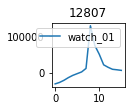

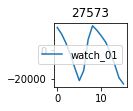

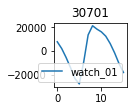

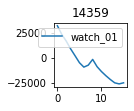

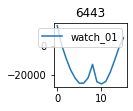

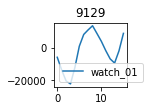

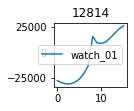

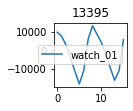

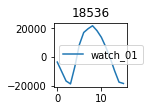

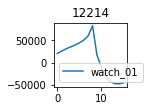

(154224, 16)


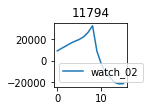

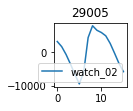

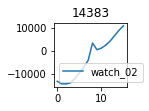

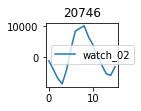

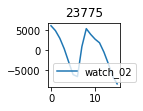

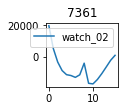

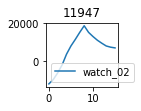

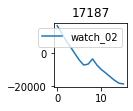

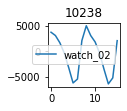

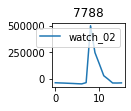

(103727, 16)


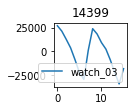

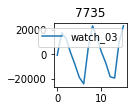

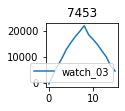

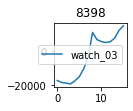

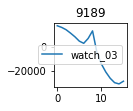

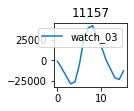

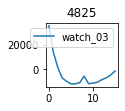

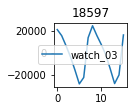

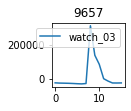

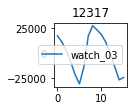

(46793, 16)


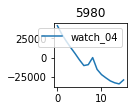

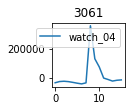

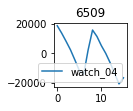

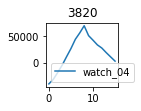

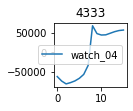

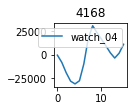

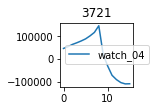

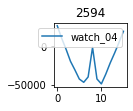

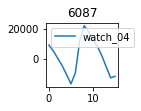

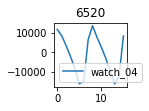

(113099, 16)


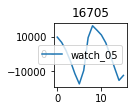

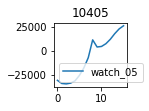

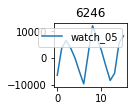

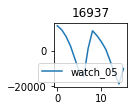

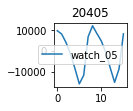

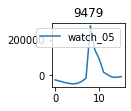

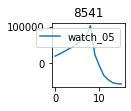

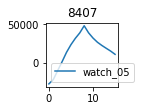

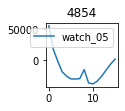

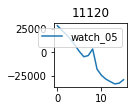

(128987, 16)


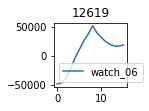

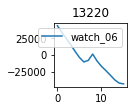

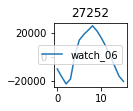

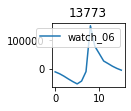

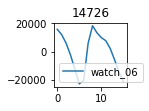

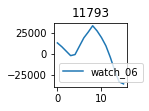

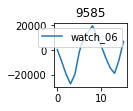

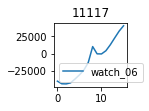

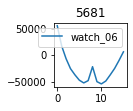

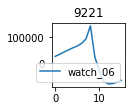

In [33]:
#using clustering for finding good heartbeat
from sklearn.cluster import KMeans

z_hbs=[]
for ii in range(0,6):
    z_hbs.append(zscore(hbs[ii],axis=1))
    km=KMeans(n_clusters=10)
    km.fit(z_hbs[ii])
    print(hbs[ii].shape)
    for i in np.arange(0,10):
        # plt.figure(figsize=(10,10))
        plt.subplot(3,4,i+1)
        plt.plot(np.mean(hbs[ii][np.where(km.labels_==i)[0],:],axis=0))
        # add legend
        plt.legend(['watch_0'+str(ii+1)])
        plt.title(np.where(km.labels_==i)[0].size)
        
        plt.show()

In [40]:
# calculate the first and second derivative of the good clusters of filtered PPG signal for each subject

firstdriv1=[]
firstdriv1_avg=[]
total_first_avg=[]

seconddriv1=[]
seconddriv1_avg=[]
total_second_avg=[]

good_clusters=[[1,2,5,7],[1,3,4,8],[0,1,5,7,9],[2,8,9],[0,2,3,4],[2,4,6]]


for i2 in range(0,6):
    i3=len(good_clusters[i2])
    for i1 in range(0,i3):
        firstdriv1.append((np.diff(np.mean(hbs[0][np.where(km.labels_==good_clusters[i2][i1])[0],:],axis=0))))
        seconddriv1.append((np.diff(firstdriv1[i1])))

        firstdriv1_avg.append(np.sum(firstdriv1[i1][0:np.argmax(firstdriv1[i1])])/np.argmax(firstdriv1[i1]))
        seconddriv1_avg.append(np.sum(seconddriv1[i1][0:np.argmax(seconddriv1[i1])])/np.argmax(seconddriv1[i1]))
        # print(f'firstdriv1_avg(watch_0{i2}){good_clusters[i2][i1]}={firstdriv1_avg[i1]}')
   
    total_first_avg.append(np.sum(firstdriv1_avg)/i3)
    total_second_avg.append(np.sum(seconddriv1_avg)/i3)
    print(f'total_first_avg(watch_0{i2})={np.round(total_first_avg[i2],4)}')
    print(f'total_second_avg(watch_0{i2})={np.round(total_second_avg[i2],4)}\n')
    

total_first_avg(watch_00)=860.0422
total_second_avg(watch_00)=892.8588

total_first_avg(watch_01)=1720.0844
total_second_avg(watch_01)=1785.7175

total_first_avg(watch_02)=2239.358
total_second_avg(watch_02)=2318.1092

total_first_avg(watch_03)=4600.6772
total_second_avg(watch_03)=4765.4896

total_first_avg(watch_04)=4310.5501
total_second_avg(watch_04)=4466.9759

total_first_avg(watch_05)=6615.8141
total_second_avg(watch_05)=6857.9422



In [24]:
# plot the matrix of features extraction
import numpy as np
import pandas as pd

data_matrix2=np.array([[50.50,49.15,0,46.53,48.07,48.39,47.81],
                        [4.31,5.63,0,8.49,7.19,6.83,4.79],
                        [860.04,1720.08,0,2239.358,4600.67,4310.55,6615.81],
                        [892.85,1785.71,0,2318.10,4765.49,4466.97,6857.94]])
matrix2=pd.DataFrame(data_matrix2,columns=['SUB 1',	'SUB 2',	'SUB 3',	'SUB 4',    'SUB 5',    'SUB 6','sub 7'])
matrix2.index=['BPM','HRV','1st deriv.','2nd deriv.']

print(matrix2)
print("\n <<the data of 'watch-03' was corrupted and it was not usable>>")

             SUB 1    SUB 2  SUB 3     SUB 4    SUB 5    SUB 6    sub 7
BPM          50.50    49.15    0.0    46.530    48.07    48.39    47.81
HRV           4.31     5.63    0.0     8.490     7.19     6.83     4.79
1st deriv.  860.04  1720.08    0.0  2239.358  4600.67  4310.55  6615.81
2nd deiv.   892.85  1785.71    0.0  2318.100  4765.49  4466.97  6857.94

 <<the data of 'watch-03' was corrupted and it was not usable>>


In [25]:
# question3
print(f'matrix fmri:\n {matrix}\n')
print('-----------------------')
print(f'matrix watch:\n {matrix2}\n')


matrix fmri:
                       SUB 1       SUB 2       SUB 3       SUB 4       SUB 5  \
DMN mean           0.006718    0.004102    0.001009    0.005836    0.009199   
Carotid velocity  39.820400   35.143600   35.300200   55.469200   55.307600   
LV area            0.000000  457.000000  284.000000  209.000000  128.000000   
LV thick           0.000000  318.000000  418.000000    0.067500    0.702790   
Aorta velocity    68.410000   64.690000   63.700000   66.100000   52.910000   

                       SUB 6       SUB 7  
DMN mean            0.025893    0.011513  
Carotid velocity   38.301100   53.622300  
LV area           486.000000  196.000000  
LV thick          469.000000   75.000000  
Aorta velocity     59.260000   64.470000  

-----------------------
matrix watch:
              SUB 1    SUB 2  SUB 3     SUB 4    SUB 5    SUB 6    sub 7
BPM          50.50    49.15    0.0    46.530    48.07    48.39    47.81
HRV           4.31     5.63    0.0     8.490     7.19     6.83     4.

In [27]:
# question 3
# define function to "calculate the correlation between  each row of the matrix with each row of the matrix2"
import numpy as np
import pandas as pd
import scipy.stats as stats

def corr_row(matrix,matrixx,flag):
    if flag=="mri_smart":
        corr_matrix=np.zeros([matrix.shape[0],matrixx.shape[1]])
        p_value=np.zeros([matrix.shape[0],matrixx.shape[1]])
        for i in range(0,matrix.shape[0]):
            for j in range(0,matrixx.shape[1]):
                corr_matrix[i,j]=stats.pearsonr(matrix.iloc[i,:],matrixx.iloc[:,j])[0]
                p_value[i,j]=stats.pearsonr(matrix.iloc[i,:],matrixx.iloc[:,j])[1]
    elif flag=="smart_smart" or flag=="mri_mri":
        corr_matrix=np.zeros([matrix.shape[0],matrixx.shape[0]])
        p_value=np.zeros([matrix.shape[0],matrixx.shape[1]])
        for i in range(0,matrix.shape[0]):
            for j in range(0,matrixx.shape[0]):
                corr_matrix[i,j]=stats.pearsonr(matrix.iloc[i,:],matrixx.iloc[j,:])[0]
                p_value[i,j]=stats.pearsonr(matrix.iloc[i,:],matrixx.iloc[j,:])[1]
    
    plt.imshow(corr_matrix)
    plt.colorbar()
    plt.title(f'correlation matrix {flag}')
    plt.show()

    return corr_matrix,p_value

In [42]:
# plot scatter plot of the correlation matrix

from pyexpat import model
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
def  scatter_plot(matrix,matrix2,p_value1,i1,j1,pl):
    k=1
    for i in range(0,i1):
        for j in range(0,j1):
            
            plt.subplot(5,pl,k)
            k=k+1
            # extract the first row of the matrix   
            matrix_first_row=matrix.iloc[i,:]
            matrix2_first_row=matrix2.iloc[j,:]
            sub=['SUB 1','SUB 2','SUB 3','SUB 4','SUB 5','SUB 6','SUB 7']
            # print(f'{matrix_first_row}')
            # print(f'{matrix2_first_row}')

            sns.scatterplot(x=matrix_first_row, y=matrix2_first_row)
            plt.title(f'p_value={np.round(p_value1[i, j], 4)}', fontsize=8)
            
            
            # show labels of the value as sub1 sub2 sub3 sub4 sub5 sub6
            for ii in range(0,7):
            # show the  value of scatter  by multi color
                plt.text(matrix_first_row[ii],matrix2_first_row[ii],sub[ii],fontsize=6)   # show the labels of the value 
    
            
    plt.show()

In [29]:
# define function to calculate bonferroni correction
def bonferroni(p_value,n):
    p_value_bonferroni=np.multiply(p_value,n)#p_value*n
    return p_value_bonferroni

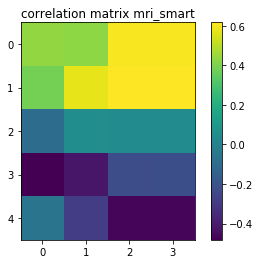

[[ 0.43852122  0.4313778   0.60557732  0.60554173]
 [ 0.38750896  0.57726986  0.61784718  0.61737313]
 [-0.09401291  0.05656073  0.04850397  0.04870792]
 [-0.48228296 -0.41731691 -0.22017149 -0.21993121]
 [-0.06098038 -0.28286187 -0.46844419 -0.4680484 ]]


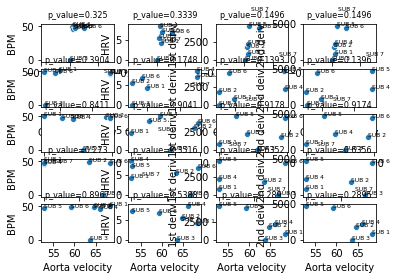

bonferroni_mri_smart=
[[19.8255 20.3656  9.1236  9.1255]
 [23.8146 10.6605  8.4946  8.5185]
 [51.3073 55.1521 55.983  55.9619]
 [16.656  21.4466 38.7483 38.7714]
 [54.6968 32.8654 17.6319 17.6602]]


In [45]:
# smartwatch vs MRI correlations

# transpose the matrix
matrix21=matrix2.T

# call the function to calculate the correlation matrix
corr_matrix_mri_smart,p_value_mri_smart=corr_row(matrix,matrix21,"mri_smart")
print(f'{corr_matrix_mri_smart}')

# call the function to plot the scatter plot
scatter_plot(matrix,matrix2,p_value_mri_smart,5,4,4)


# call the function to calculate the bonferroni correction
p_value_bonferroni_mri_smart=bonferroni(p_value_mri_smart,61)
print(f'bonferroni_mri_smart=\n{np.round(p_value_bonferroni_mri_smart,4)}')


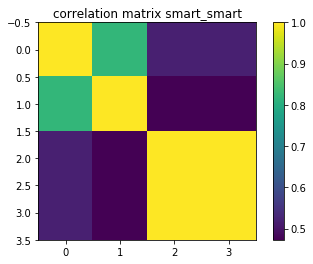

[[1.         0.82276642 0.51854833 0.51866362]
 [0.82276642 1.         0.47328277 0.47296159]
 [0.51854833 0.47328277 1.         0.99999962]
 [0.51866362 0.47296159 0.99999962 1.        ]]


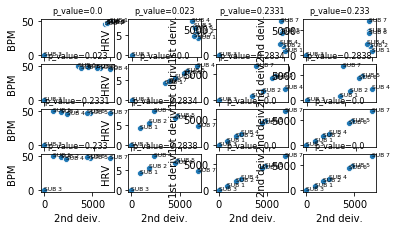

bonferroni_smart_smart=
[[ 0.      1.4048 14.2191 14.2116  0.      0.      0.    ]
 [ 1.4048  0.     17.2879 17.3106  0.      0.      0.    ]
 [14.2191 17.2879  0.      0.      0.      0.      0.    ]
 [14.2116 17.3106  0.      0.      0.      0.      0.    ]]


In [47]:
# Smartwatch vs smartwatch correlations
# call the function to calculate the correlation matrix
corr_matrix_smart_smart,p_value_smart_smart=corr_row(matrix2,matrix2,"smart_smart")
print(f'{corr_matrix_smart_smart}')

# call the function to plot the scatter plot
scatter_plot(matrix2,matrix2,p_value_smart_smart,4,4,4)

# call the function to calculate the bonferroni correction
p_value_bonferroni_smart_smart=bonferroni(p_value_smart_smart,61)
print(f'bonferroni_smart_smart=\n{np.round(p_value_bonferroni_smart_smart,4)}')


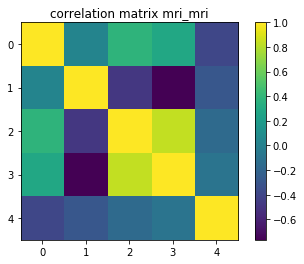

[[ 1.          0.0329873   0.38264925  0.29040175 -0.38722218]
 [ 0.0329873   1.         -0.4796491  -0.76583238 -0.28838775]
 [ 0.38264925 -0.4796491   1.          0.83872814 -0.15492311]
 [ 0.29040175 -0.76583238  0.83872814  1.         -0.08470782]
 [-0.38722218 -0.28838775 -0.15492311 -0.08470782  1.        ]]


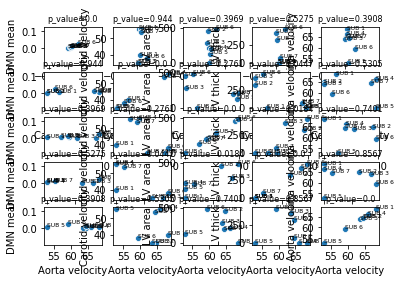

bonferroni_mri_mri=
[[ 0.     57.5858 24.2102 32.1788 23.8379  0.      0.    ]
 [57.5858  0.     16.8398  2.7279 32.3617  0.      0.    ]
 [24.2102 16.8398  0.      1.1197 45.1485  0.      0.    ]
 [32.1788  2.7279  1.1197  0.     52.2594  0.      0.    ]
 [23.8379 32.3617 45.1485 52.2594  0.      0.      0.    ]]


In [49]:
# MRI vs MRI correlations
# call the function to calculate the correlation matrix
corr_matrix_mri_mri,p_value_mri_mri=corr_row(matrix,matrix,"mri_mri")
print(f'{corr_matrix_mri_mri}')

# call the function to plot the scatter plot
scatter_plot(matrix,matrix,p_value_mri_mri,5,5,5)

# call the function to calculate the bonferroni correction
p_value_bonferroni_mri_mri=bonferroni(p_value_mri_mri,61)

print(f'bonferroni_mri_mri=\n{np.round(p_value_bonferroni_mri_mri,4)}')